In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw
import librosa
import math
from spafe.features.lpc import lpc, lpcc, lpc2lpcc

In [2]:
def plot_signal(signals,x):
    for i in range(len(signals)):
        plt.figure(x*10 + i+1)
        plt.title("voice {}".format(i+1))
        plt.plot(signals[i])

In [3]:
def normalize_signal(signals):
    for i in range(len(signals)):
        temp = librosa.util.normalize(signals[i])
        for n in range(0,len(temp)):
            if abs(temp[n]) < 0.05 :
                temp[n] = 0
        temp = np.array(temp)
        signals[i] = temp
    return signals

In [4]:
def delete_silence(signals):
    for i in range(len(signals)):
        temp = []
        for data in signals[i]:
            if data != 0.0:
                temp.append(data)
        temp = np.array(temp)
        signals[i] = temp
    return signals

In [5]:
def stride_trick(a, stride_length, stride_step):
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,shape=(nrows, stride_length),strides=(stride_step*n, n))

In [6]:
def framing(sig, fs=11025, win_len=0.19, win_hop=0.08):
    
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))


    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length

In [7]:
def add_features(features,temp):
    features.append(np.average(temp))
    features.append(np.mean(temp))
    features.append(np.min(temp))
    features.append(np.max(temp))
    return features

In [8]:
def feature_extraction(list_frames):
    features_list = []
    for signalframes in list_frames:
        features=[]
        for frame in signalframes:
            features_frame = []
            # Energy
            temp = np.array([data * data for data in frame])
            features_frame = add_features(features_frame,temp)
            # ZeroCrossing
            temp = librosa.feature.zero_crossing_rate(frame, 11025)
            features_frame = add_features(features_frame,temp)
            # MFCC
            temp = librosa.feature.mfcc(frame,11025)
            features_frame = add_features(features_frame,temp)
            # LPC
            temp = librosa.lpc(frame, order=16)
            # temp = lpcc(frame, fs=11025, num_ceps=13)
            features_frame = add_features(features_frame,temp)
            # RMS
            temp = librosa.feature.rms(frame,11025)
            features_frame = add_features(features_frame,temp)
            # autocorrelate
            temp = librosa.autocorrelate(frame)
            features_frame = add_features(features_frame,temp)

            features.append(features_frame)
        features_list.append(features)
    return features_list

In [ ]:
name_voices = []
len_voices = 10

for i in range(len_voices):
    y, sr = librosa.load("train/{}.ogg".format(i+1))
    name_voices.append(y)

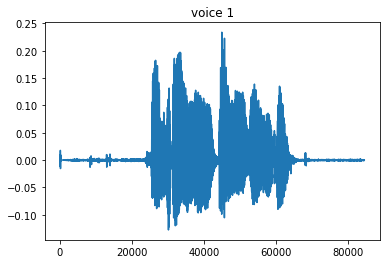

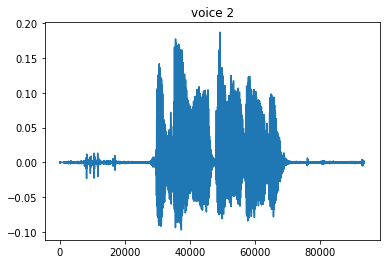

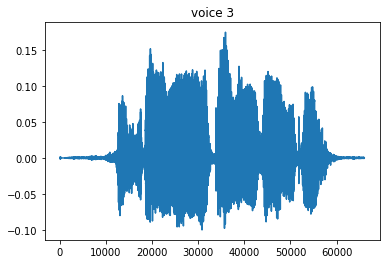

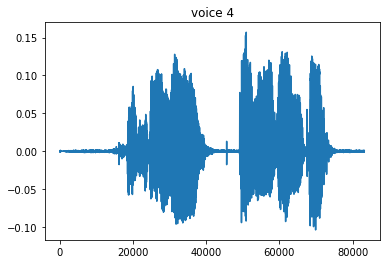

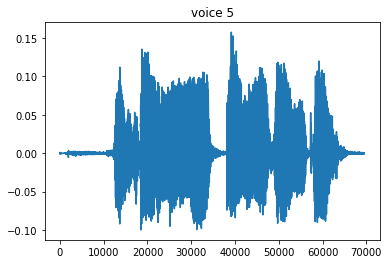

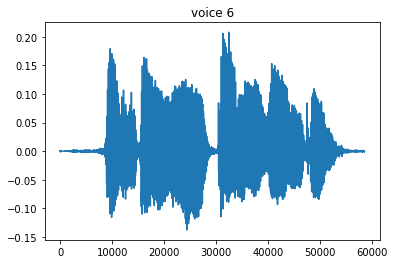

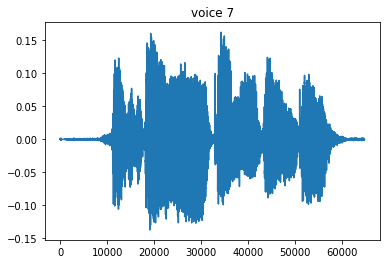

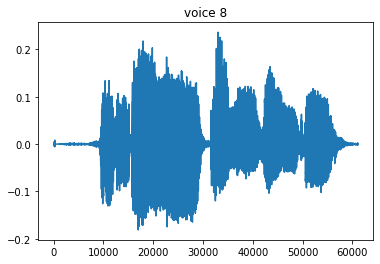

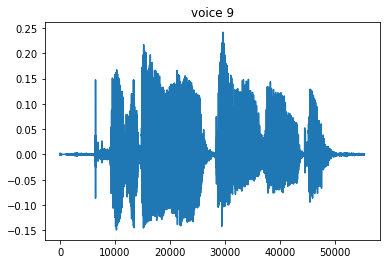

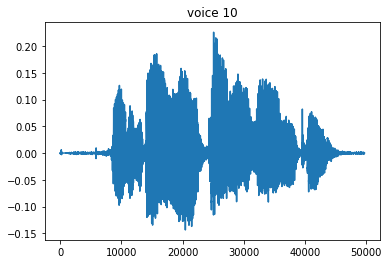

In [10]:
plot_signal(name_voices,0)

In [11]:
name_voices = normalize_signal(name_voices)

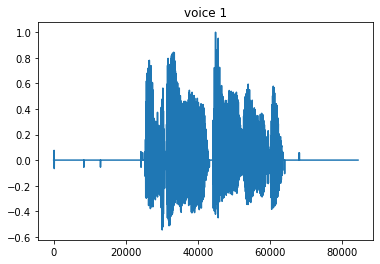

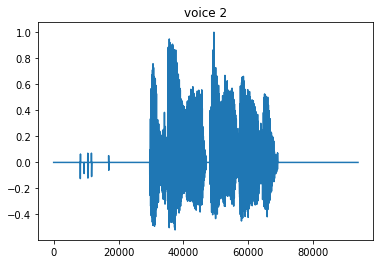

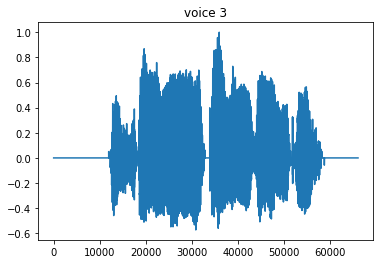

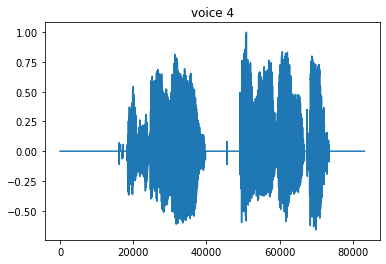

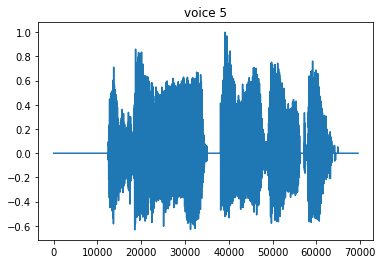

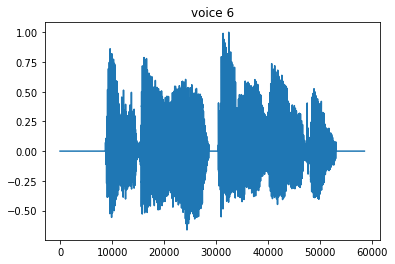

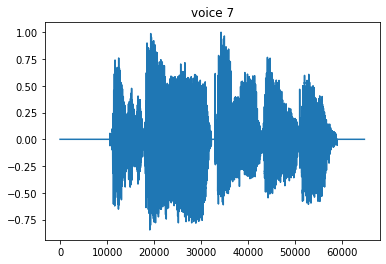

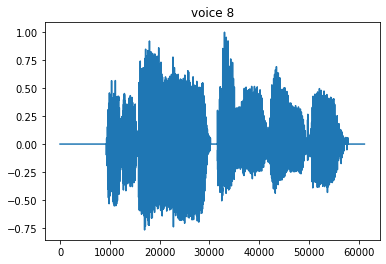

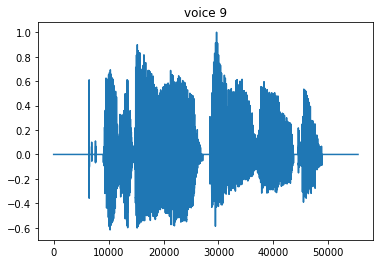

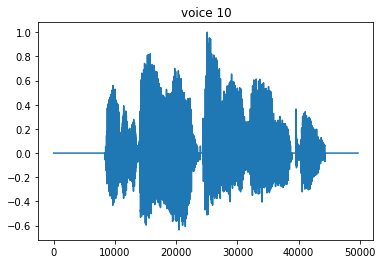

In [12]:
plot_signal(name_voices,1)

In [13]:
name_voices = delete_silence(name_voices)

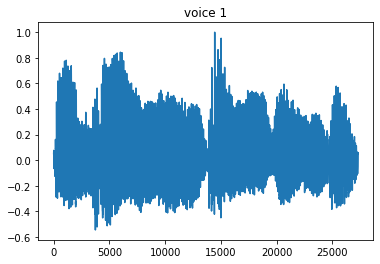

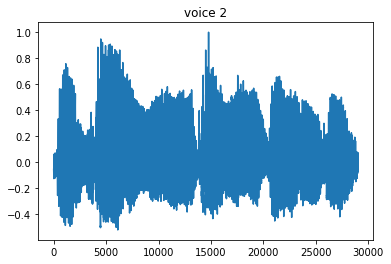

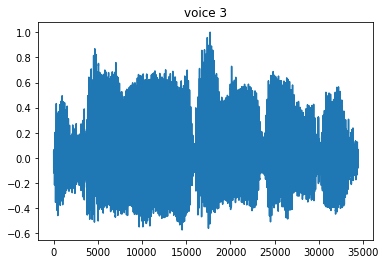

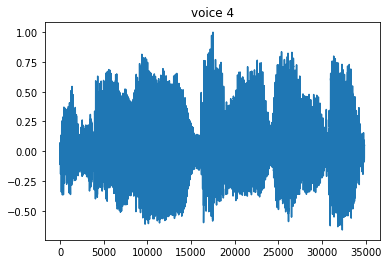

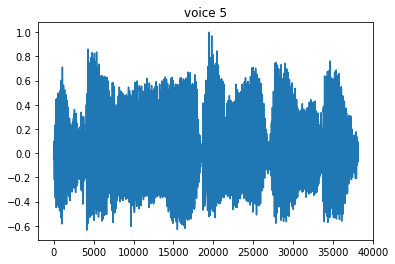

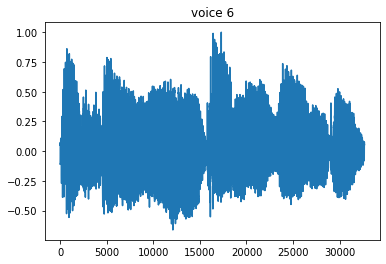

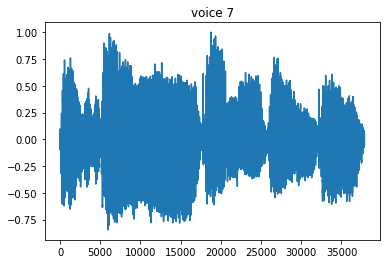

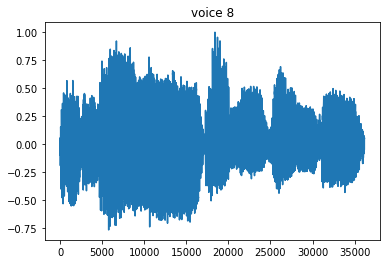

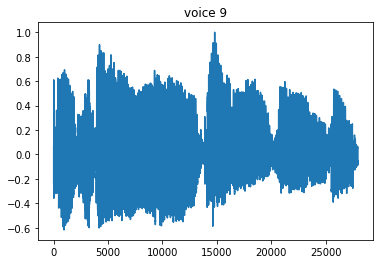

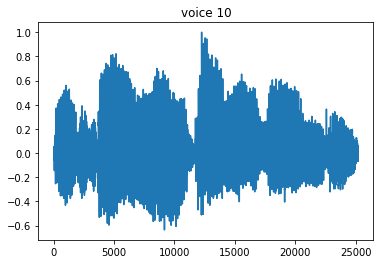

In [14]:
plot_signal(name_voices,1)

In [ ]:
name_voices_frames = []
for signal in name_voices:
    temp, le = framing(signal,11025)
    name_voices_frames.append(temp)

name_voices_features = []
name_voices_features = feature_extraction(name_voices_frames)

In [16]:
dtw_1 = np.zeros((len(name_voices_features),len(name_voices_features)))
for first in range(len(name_voices_features)):
    for second in range(len(name_voices_features)):
        dtw_1[first][second] , dummy = fastdtw(name_voices_features[first], name_voices_features[second])

for row in dtw_1:
    print(' '.join(map(str, row)))

num = 0
sum = 0
row_avg =[]
for i in range(0,len_voices):
    row_sum = 0
    row_num = 0
    for j in range(0,len_voices):
        if i != j:
            sum += dtw_1[i][j]
            num += 1
            row_sum += dtw_1[i][j]
            row_num += 1
    temp = row_sum/row_num
    row_avg.append(temp)

avg = sum/num

print("\nTotal AVG = ",avg)
print("Total MAX = ",max(row_avg))
print("Total MIN = ",min(row_avg),"\n")
for i in range(len(row_avg)):
    print("row AVG "+str(i+1),row_avg[i])

reference_signal_feature = name_voices_features[0]
min_dist = abs(avg - row_avg[0])
index = 0
for i in range(len(row_avg)):
    dist = abs(avg - row_avg[i])
    if dist < min_dist:
        reference_signal_feature = name_voices_features[i]
        min_dist = dist
        index = i

0.0 1569.7036225015788 3201.605403307699 4280.465473334767 4821.148534764416 2488.2051144509296 5618.740712989041 4468.693337768519 2452.9141664207505 2337.218271686153
1569.7036225015788 0.0 3232.5849140043324 3900.162519608868 4369.084685590519 2388.7054706889094 5357.899189179888 4390.442194563834 2666.8444110784326 2288.5580549640817
3201.605403307699 3232.5849140043324 0.0 3512.068882403238 2709.431456774124 2456.7750695356326 4346.781099105144 3858.4919012099595 2856.374774505235 2571.122733453425
4280.465473334767 3900.162519608868 3512.068882403238 0.0 3310.6775731170037 3772.0222694732747 6392.193258951642 6037.551440690539 4309.904804614699 3792.300708202011
4821.148534764416 4369.084685590519 2709.431456774124 3310.6775731170037 0.0 3288.1135916255603 5566.208695113606 5442.585122895784 4178.827652465292 3747.7295081938787
2488.2051144509296 2388.7054706889094 2456.7750695356326 3772.0222694732747 3288.1135916255603 0.0 5239.123920339934 4068.645097287227 2287.257475210439 2

In [ ]:
others_words = []
len_ow = 7
for i in range(len_ow):
    y, sr = librosa.load("test/{}.ogg".format(i+1))
    others_words.append(y)

In [18]:
others_words = normalize_signal(others_words)

In [19]:
others_words = delete_silence(others_words)

In [ ]:
others_frames = []
for signal in others_words:
    temp, le = framing(signal,11025)
    others_frames.append(temp)

others_test_features = []

others_test_features =feature_extraction(others_frames)

dtw_others_feature = []
for i in range(0,len_ow):
    temp , dummy = fastdtw(reference_signal_feature, others_test_features[i])
    dtw_others_feature.append(temp)

In [21]:
print("results Others Test = ",dtw_others_feature)

results Others Test =  [8547.991110307277, 3334.819731865404, 3748.5624055818025, 2336.3862177720202, 5504.807597195899, 3129.6728884451522, 3238.230206293284]


In [22]:
all_test = []
for i in range(len(dtw_others_feature)):
    all_test.append(abs(avg - dtw_others_feature[i]))

print(all_test)

[4824.69348644815, 388.477891993723, 25.264781722675707, 1386.9114060871066, 1781.509973336772, 593.6247354139746, 485.0674175658428]
